In [1]:
import glob
import json
import os
import random as rnd
import shutil

import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import StratifiedGroupKFold
from tensorflow import keras
from tqdm import tqdm

from src.utils import (
    DataGenerator,
    TripletsGenerator,
    euclidean_distance,
    loss,
    make_callbacks,
    make_model,
    plot_history,
    plot_triplets,
)

InteractiveShell.ast_node_interactivity = "all"

In [2]:
class CFG:
    def __init__(
        self,
    ):
        self.seed = 39
        self.batch_size = 64
        self.img_size = (512, 60)
        self.crop = self.img_size < (512, 81)
        self.n_chanels = 1
        self.n_folds = 6
        self.fold = 2
        self.norm = False
        self.emb_len = 1024
        self.kernel_size = (5, 2)
        self.act_fn = "relu"
        self.n_epochs = 60
        self.input_shape = (*self.img_size, self.n_chanels)

In [3]:
cfg = CFG()

In [4]:
cfg.input_shape

(512, 60, 1)

In [5]:
root_dir = "/app/_data/artist_data/"
mod_dir = "/app/_data/artist_data/models/test_arch/tripl_6/"

In [6]:
train = pd.read_csv(os.path.join(root_dir, "train.csv"))
train = train[train["artistid_count"] != 1].reset_index(drop=True)

## train_val_split

In [7]:
gkf = StratifiedGroupKFold(n_splits=cfg.n_folds, shuffle=True, random_state=cfg.seed)
for n, (train_ids, val_ids) in enumerate(
    gkf.split(
        X=train[["artistid", "artistid_count"]],
        y=train["artistid_count"],
        groups=train["artistid"],
    )
):
    train.loc[val_ids, "fold"] = n

In [8]:
train_df = train[train["fold"] != cfg.fold].reset_index(drop=True)
val_df = train[train["fold"] == cfg.fold].reset_index(drop=True)

## DataGenerator

In [9]:
# artist_ids = train_df["artistid"].unique().tolist()
# path2artist = train_df.set_index("path")["artistid"].to_dict()
# track2artist = train_df.set_index("trackid")["artistid"].to_dict()
# artis2track = train_df.groupby("artistid").agg(list)["trackid"].to_dict()
# artis2path = train_df.groupby("artistid").agg(list)["path"].to_dict()

In [10]:
train_gen = TripletsGenerator(
    data=train_df,
    img_size=cfg.img_size,
    batch_size=cfg.batch_size,
    norm=cfg.norm,
    n_chanels=cfg.n_chanels,
    shuffle=True,
    debug=False,
)
val_gen = TripletsGenerator(
    data=val_df,
    img_size=cfg.img_size,
    batch_size=cfg.batch_size,
    norm=cfg.norm,
    n_chanels=cfg.n_chanels,
    shuffle=True,
    debug=False,
)

In [11]:
imgs, y = train_gen.__getitem__(9)
imgs["anchor"].shape

(64, 512, 60, 1)

In [12]:
# plot_triplets(df=train, cfg=cfg, n_examples=5)

## Model

In [13]:
# def embNet(input_shape, dropout_rate=0.1, embedding_len=1024, activation_fn="relu"):
#     base_model = keras.applications.mobilenet_v2.MobileNetV2(
#         input_shape=input_shape,
#         alpha=1.0,
#         include_top=False,
#         weights=None,
#         pooling=None,
#     )
#     # base_model = keras.applications.resnet50.ResNet50(
#     #     include_top=False,
#     #     weights=None,
#     #     input_tensor=None,
#     #     input_shape=input_shape,
#     #     pooling=None,
#     # )
#     input = keras.layers.Input(shape=input_shape)
#     x=keras.applications.mobilenet.preprocess_input(input)
#     base_model = keras.applications.mobilenet_v2.MobileNetV2(
#         input_tensor=x,
#         alpha=1.0,
#         include_top=False,
#         weights=None,
#         pooling=None,
#     )
#     x = base_model(x)
#     x = keras.layers.Flatten()(x)
#     x = keras.layers.Dense(embedding_len * 4, activation=activation_fn, name="dense_1")(
#         x
#     )
#     x = keras.layers.Dense(embedding_len * 2, activation=activation_fn, name="dense_2")(
#         x
#     )
#     x = keras.layers.Dense(embedding_len, activation=None, name="dense_3")(x)
#     x = keras.layers.Reshape((1, -1))(x)
#     embedding_net = keras.Model(inputs=base_model.input, outputs=x, name="embedding")
#     return embedding_net
# embedding_net = embNet(
#     input_shape=cfg.input_shape,
#     dropout_rate=0.1,
#     embedding_len=cfg.emb_len,
#     activation_fn="relu",
# )
# embedding_net.summary()

In [14]:
def embNet(
    input_shape,
    kernel_size=3,
    dropout_rate=0.1,
    embedding_len=1024,
    activation_fn="relu",
    padding="valid",
    dense_activation="relu",
):
    base_model = tf.keras.models.Sequential(
        [
            keras.layers.Conv2D(
                filters=1,
                kernel_size=kernel_size,
                activation=activation_fn,
                input_shape=input_shape,
                padding=padding,
                name="conv_1",
            ),
            keras.layers.Conv2D(
                filters=1,
                kernel_size=kernel_size,
                activation=activation_fn,
                padding=padding,
                name="conv_2",
            ),
            keras.layers.Dropout(rate=dropout_rate, name="dropout1"),
            keras.layers.MaxPooling2D(
                pool_size=(2, 2), strides=1, padding="same", name="max_1"
            ),
            keras.layers.Conv2D(
                filters=1,
                kernel_size=kernel_size,
                activation=activation_fn,
                padding=padding,
                name="conv_3",
            ),
            keras.layers.Conv2D(
                filters=1,
                kernel_size=kernel_size,
                activation=activation_fn,
                padding=padding,
                name="conv_4",
            ),
            keras.layers.Dropout(rate=dropout_rate, name="dropout2"),
            keras.layers.MaxPooling2D(
                pool_size=(2, 2), strides=1, padding="same", name="max_2"
            ),
            keras.layers.Conv2D(
                filters=1,
                kernel_size=kernel_size,
                activation=activation_fn,
                padding=padding,
                name="conv_5",
            ),
            keras.layers.Conv2D(
                filters=1,
                kernel_size=kernel_size,
                activation=activation_fn,
                padding=padding,
                name="conv_6",
            ),
            keras.layers.Dropout(rate=dropout_rate, name="dropout3"),
            keras.layers.MaxPooling2D(
                pool_size=(2, 2), strides=1, padding="same", name="max_3"
            ),
            keras.layers.Flatten(name="flatten_base"),
            keras.layers.Dense(embedding_len, activation=None, name="dense_base"),
        ]
    )
    x = keras.layers.Reshape((1, -1))(base_model.output)
    embedding_net = keras.Model(inputs=base_model.input, outputs=x, name="embedding")
    return embedding_net

In [15]:
embedding_net = embNet(
    input_shape=cfg.input_shape,
    kernel_size=3,
    dropout_rate=0.1,
    embedding_len=cfg.emb_len,
    activation_fn="relu",
    padding="valid",
    dense_activation="relu",
)

In [16]:
embedding_net.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1_input (InputLayer)   [(None, 512, 60, 1)]      0         
                                                                 
 conv_1 (Conv2D)             (None, 510, 58, 1)        10        
                                                                 
 conv_2 (Conv2D)             (None, 508, 56, 1)        10        
                                                                 
 dropout1 (Dropout)          (None, 508, 56, 1)        0         
                                                                 
 max_1 (MaxPooling2D)        (None, 508, 56, 1)        0         
                                                                 
 conv_3 (Conv2D)             (None, 506, 54, 1)        10        
                                                                 
 conv_4 (Conv2D)             (None, 504, 52, 1)        10

In [17]:
def low_res_models(
    kernel_size=(9, 9),
    activation_fn="relu",
    padding="valid",
    input_shape=cfg.input_shape,
    n_filters=4,
    pool_size=7,
    embedding_len=1024,
):
    low_res_1 = tf.keras.models.Sequential(
        [
            tf.keras.layers.Resizing(
                height=60,
                width=60,
                interpolation="bilinear",
                crop_to_aspect_ratio=False,
                input_shape=input_shape,
                name="lr1_resize",
            ),
            keras.layers.BatchNormalization(name="lr1_bnorm"),
            keras.layers.Conv2D(
                filters=n_filters,
                kernel_size=kernel_size,
                activation=activation_fn,
                padding=padding,
                name="lr1_conv",
            ),
            keras.layers.MaxPooling2D(
                pool_size=pool_size, strides=1, padding=padding, name="lr1_maxpool"
            ),
            keras.layers.Flatten(name="lr1_flatten"),
            keras.layers.Dense(embedding_len, activation=None, name="lr1_dense"),
            keras.layers.Reshape((1, -1), name="lr1_reshape"),
        ],
        name="low_res_1",
    )
    low_res_2 = tf.keras.models.Sequential(
        [
            tf.keras.layers.Resizing(
                height=30,
                width=30,
                interpolation="bilinear",
                crop_to_aspect_ratio=False,
                input_shape=input_shape,
                name="lr2_resize",
            ),
            keras.layers.BatchNormalization(name="lr2_bnorm"),
            keras.layers.Conv2D(
                filters=n_filters,
                kernel_size=kernel_size,
                activation=activation_fn,
                padding=padding,
                name="lr2_conv",
            ),
            keras.layers.MaxPooling2D(
                pool_size=pool_size, strides=1, padding=padding, name="lr2_maxpool"
            ),
            keras.layers.Flatten(name="lr2_flatten"),
            keras.layers.Dense(embedding_len, activation=None, name="lr2_dense"),
            keras.layers.Reshape((1, -1), name="lr2_reshape"),
        ],
        name="low_res_2",
    )
    return low_res_1, low_res_2

In [18]:
low_res_1, low_res_2 = low_res_models(
    kernel_size=(9, 9),
    activation_fn="relu",
    padding="valid",
    input_shape=cfg.input_shape,
    n_filters=4,
    pool_size=7,
    embedding_len=1024,
)

In [19]:
low_res_1.summary()

Model: "low_res_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lr1_resize (Resizing)       (None, 60, 60, 1)         0         
                                                                 
 lr1_bnorm (BatchNormalizati  (None, 60, 60, 1)        4         
 on)                                                             
                                                                 
 lr1_conv (Conv2D)           (None, 52, 52, 4)         328       
                                                                 
 lr1_maxpool (MaxPooling2D)  (None, 46, 46, 4)         0         
                                                                 
 lr1_flatten (Flatten)       (None, 8464)              0         
                                                                 
 lr1_dense (Dense)           (None, 1024)              8668160   
                                                         

In [20]:
low_res_2.summary()

Model: "low_res_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lr2_resize (Resizing)       (None, 30, 30, 1)         0         
                                                                 
 lr2_bnorm (BatchNormalizati  (None, 30, 30, 1)        4         
 on)                                                             
                                                                 
 lr2_conv (Conv2D)           (None, 22, 22, 4)         328       
                                                                 
 lr2_maxpool (MaxPooling2D)  (None, 16, 16, 4)         0         
                                                                 
 lr2_flatten (Flatten)       (None, 1024)              0         
                                                                 
 lr2_dense (Dense)           (None, 1024)              1049600   
                                                         

In [21]:
embedding_net.output_shape

(None, 1, 1024)

In [22]:
def siamese_model(input_shape, embedding_net, low_res_1, low_res_2):
    input_anchor = keras.layers.Input(shape=input_shape, name="anchor")
    input_positive = keras.layers.Input(shape=input_shape, name="positive")
    input_negative = keras.layers.Input(shape=input_shape, name="negative")

    embedding_anchor = embedding_net(input_anchor)
    embedding_positive = embedding_net(input_positive)
    embedding_negative = embedding_net(input_negative)

    lr1_anchor = low_res_1(input_anchor)
    lr1_positive = low_res_1(input_positive)
    lr1_negative = low_res_1(input_negative)

    lr2_anchor = low_res_2(input_anchor)
    lr2_positive = low_res_2(input_positive)
    lr2_negative = low_res_2(input_negative)
    anchor_output = tf.keras.layers.concatenate(
        [embedding_anchor, lr1_anchor, lr2_anchor], axis=1
    )
    pos_output = tf.keras.layers.concatenate(
        [embedding_positive, lr1_positive, lr2_positive], axis=1
    )
    neg_output = tf.keras.layers.concatenate(
        [embedding_negative, lr1_negative, lr2_negative], axis=1
    )
    output = keras.layers.concatenate([anchor_output, pos_output, neg_output])
    siamese_net = tf.keras.models.Model(
        inputs=[input_anchor, input_positive, input_negative],
        outputs=output,
        name="siamese",
    )
    return siamese_net

In [23]:
siamese_net = siamese_model(
    input_shape=cfg.input_shape,
    embedding_net=embedding_net,
    low_res_1=low_res_1,
    low_res_2=low_res_2,
)

In [24]:
siamese_net.output_shape

(None, 3, 3072)

In [25]:
def triplet_loss(margin=1):
    def loss(y_true, y_pred):
        anchor, positive, negative = (
            y_pred[:, 0, ...],
            y_pred[:, 1, ...],
            y_pred[:, 2, ...],
        )
        positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
        negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
        return tf.maximum(positive_dist - negative_dist + margin, 0.0)

    return loss

In [26]:
callbacks = make_callbacks(
    path=mod_dir, monitor="val_loss", mode="min", reduce_patience=10, stop_patience=20
)

In [27]:
siamese_net.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=triplet_loss())

In [28]:
# keras.mixed_precision.set_global_policy("mixed_float16")

In [30]:
# shutil.rmtree('/app/_data/artist_data/models/test_arch/tripl_5/backup')

In [31]:
history = siamese_net.fit(
    x=train_gen,
    steps_per_epoch=train_gen.__len__(),
    validation_data=val_gen,
    callbacks=callbacks,
    epochs=10,
    use_multiprocessing=True,
    workers=10,
)

Epoch 2/10
1418/2179 [==================>...........] - ETA: 1:21 - loss: 0.5123
Epoch 2: val_loss improved from inf to 0.00000, saving model to /app/_data/artist_data/models/test_arch/tripl_6/model.h5
2179/2179 [==============================] - 294s 132ms/step - loss: 0.3334 - val_loss: 0.0000e+00 - lr: 0.0010
Epoch 3/10
2179/2179 [==============================] - ETA: 0s - loss: 0.0000e+00
Epoch 3: val_loss did not improve from 0.00000
2179/2179 [==============================] - 293s 134ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00 - lr: 0.0010
Epoch 4/10
2179/2179 [==============================] - ETA: 0s - loss: 0.0000e+00
Epoch 4: val_loss did not improve from 0.00000
2179/2179 [==============================] - 299s 137ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00 - lr: 0.0010
Epoch 5/10
2179/2179 [==============================] - ETA: 0s - loss: 0.0000e+00
Epoch 5: val_loss did not improve from 0.00000
2179/2179 [==============================] - 310s 142ms/step - l

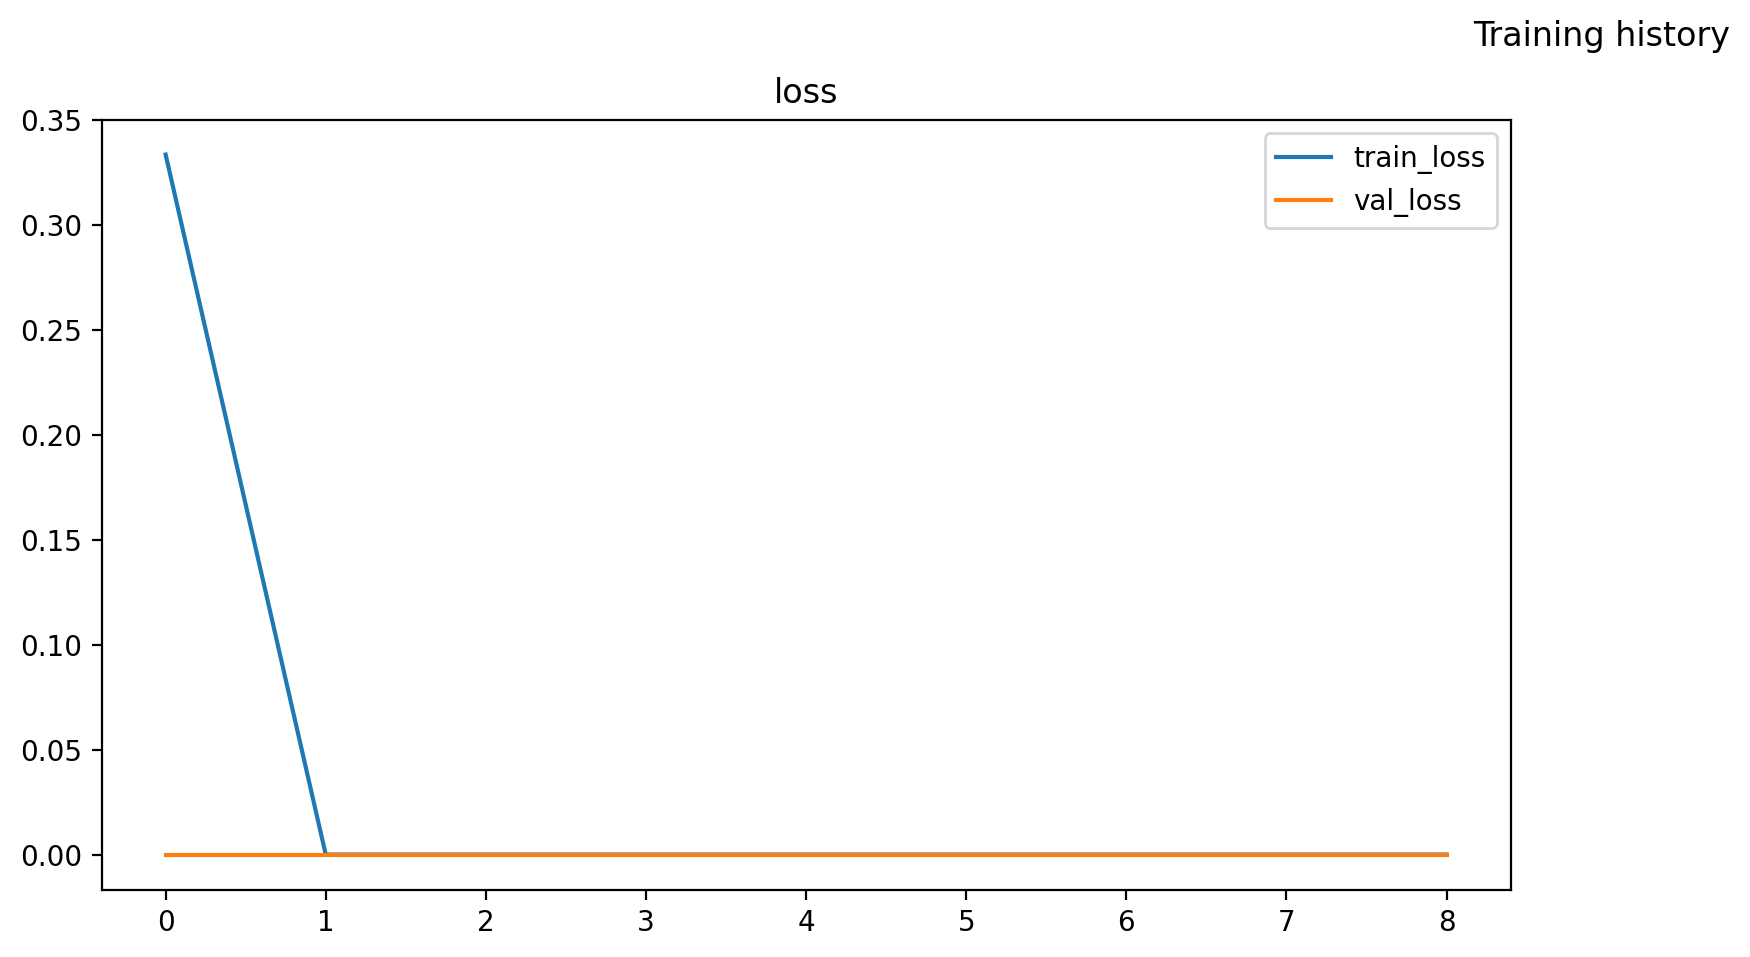

In [32]:
plot_history(history.history)

In [ ]:
def save_params(mod_dir, model, history, cfg, loss="constr"):
    train_history = history.history
    min_val_loss = np.min(train_history["val_loss"])

    for k in train_history.keys():
        train_history[k] = list(map(float, train_history[k]))
    model.save(
        os.path.join(mod_dir, f"model_{min_val_loss}.h5"),
    )
    config = {
        "loss": loss,
        "history": train_history,
        "norm": cfg.norm,
        "fold": cfg.fold,
        "model": {
            "eff": False,
            "input_shape": cfg.input_shape,
            "embedding_len": cfg.emb_len,
            "kernel_size": cfg.kernel_size,
            "activation_fn": cfg.act_fn,
            "batch_norm": False,
        },
    }
    with open(os.path.join(mod_dir, "config.json"), "w") as f:
        json.dump(config, f)
    model.save(os.path.join(mod_dir, f"model_{min_val_loss}"), include_optimizer=False)
    print(
        f'min_val_loss = {min_val_loss}, model saved to {os.path.join(mod_dir, f"model_{min_val_loss}")}'
    )

In [ ]:
save_params(mod_dir, siamese_net, history, cfg, loss="tripl")

In [ ]:
[x.name for x in siamese_net.layers]

In [ ]:
# siamese_net(imgs[:3]).get_output('embedding')

In [41]:
embedding_net.set_weights(
    [
        w
        for w in siamese_net.weights
        if w.name in [y.name for y in embedding_net.weights]
    ]
)

In [42]:
low_res_1.set_weights(
    [
        w
        for w in siamese_net.weights
        if w.name in [y.name for y in low_res_1.weights]
    ]
)

In [43]:
low_res_2.set_weights(
    [
        w
        for w in siamese_net.weights
        if w.name in [y.name for y in low_res_2.weights]
    ]
)

In [47]:
low_res_1.predict(imgs['anchor']).shape

2/2 [==============================] - 0s 4ms/step


(64, 1, 1024)

In [37]:
val_df

,trackid,artistid,archive_features_path,path,max,min,mean,width,height,artistid_count,fold
0,105739,4,4/9/3/105739.npy,/app/_data/artist_data/train_features/4/9/3/10...,4.224643,0.0,0.444227,81.0,512.0,10,2.0
1,4,4,4/4/0/4.npy,/app/_data/artist_data/train_features/4/4/0/4.npy,3.786215,0.0,0.444095,81.0,512.0,10,2.0
2,868,4,4/8/6/868.npy,/app/_data/artist_data/train_features/4/8/6/86...,3.098363,0.0,0.370418,81.0,512.0,10,2.0
3,16333,4,4/3/3/16333.npy,/app/_data/artist_data/train_features/4/3/3/16...,5.220033,0.0,0.367171,73.0,512.0,10,2.0
4,68038,4,4/8/3/68038.npy,/app/_data/artist_data/train_features/4/8/3/68...,4.476882,0.0,0.419996,81.0,512.0,10,2.0
...,...,...,...,...,...,...,...,...,...,...,...
27699,153876,18455,5/6/7/153876.npy,/app/_data/artist_data/train_features/5/6/7/15...,5.924749,0.0,0.441504,81.0,512.0,2,2.0
27700,151291,18461,1/1/9/151291.npy,/app/_data/artist_data/train_features/1/1/9/15...,4.962697,0.0,0.382900,81.0,512.0,2,2.0
27701,155004,18461,1/4/0/155004.npy,/app/_data/artist_data/train_features/1/4/0/15...,5.474594,0.0,0.382723,81.0,512.0,2,2.0
27702,161032,18467,7/2/3/161032.npy,/app/_data/artist_data/train_features/7/2/3/16...,6.289591,0.0,0.315962,81.0,512.0,2,2.0


In [ ]:
class TestGenerator(keras.utils.Sequence):
    def __init__(
        self,
        data,
        img_size,
        batch_size=32,
        norm=False,
        n_chanels=1,
    ):
        self.data = data.reset_index(drop=True)
        self.img_size = img_size
        self.batch_size = batch_size
        self.norm = norm
        self.n_chanels = n_chanels
        self.default_img_size = (512, 81)

    def __len__(self):
        return self.data.shape[0] // self.batch_size

    def load_img(self, path):
        img = np.load(path).astype("float32")
        if self.norm:
            img -= img.min()
            img /= img.max()
        if self.img_size < self.default_img_size:
            wpad = (img.shape[1] - self.img_size[1]) // 2
            img = img[:, wpad : wpad + self.img_size[1]]
        if img.shape != self.img_size:
            wpad = self.img_size[1] - img.shape[1]
            wpad_l = wpad // 2
            wpad_r = wpad - wpad_l
            img = np.pad(
                img,
                pad_width=((0, 0), (wpad_l, wpad_r)),
                mode="constant",
                constant_values=0,
            )
        img = np.expand_dims(img, -1)
        if self.n_chanels == 3:
            img = np.concatenate([img, img, img], -1)
        return img

    def __getitem__(self, batch_ix):
        imgs = np.zeros([self.batch_size, *self.img_size, self.n_chanels])

        for i in range(self.batch_size):
            ix = i + self.batch_size * batch_ix
            img = self.load_img(self.data.loc[ix, "path"])
            imgs[i] = img

        return imgs

In [ ]:
def pairwise_distances(array):
    dists = tf.add(
        tf.reduce_sum(tf.square(array), axis=[1], keepdims=True),
        tf.reduce_sum(tf.square(tf.transpose(array)), axis=[0], keepdims=True),
    ) - 2.0 * tf.matmul(array, tf.transpose(array))
    return dists

In [ ]:
def choose_100(
    prediction,
    df,
):
    dists = pairwise_distances(prediction)
    neigh = {}
    for ix in tqdm(range(dists.shape[0])):
        trackid = df.loc[ix, "trackid"]
        nearest_100 = np.argsort(dists[ix])[:101]
        tracks_100 = df.loc[nearest_100, "trackid"].tolist()
        neigh[trackid] = {
            "tracks": [x for x in tracks_100 if x != trackid],
            "atrtistid": df.loc[ix, "artistid"],
            "artists": df.loc[nearest_100, "artistid"].tolist(),
        }

    return neigh

In [ ]:
test_gen = TestGenerator(
    data=val_df,
    img_size=cfg.img_size,
    batch_size=1,
    norm=False,
    n_chanels=1,
)

In [ ]:
pred_val = np.squeeze(embedding_net.predict(test_gen))

In [ ]:
neigh = choose_100(pred_val, val_df)

In [ ]:
dists = pairwise_distances(pred_val)

In [ ]:
sns.heatmap(pairwise_distances(pred_val[900:1000]))

In [ ]:
l = []
for k in neigh.keys():
    l.append(len([1 for x in neigh[k]["artists"] if x == neigh[k]["atrtistid"]]))

In [ ]:
plt.hist(l)
plt.show();

In [ ]:
def position_discounter(position):
    return 1.0 / np.log2(position + 1)


def get_ideal_dcg(relevant_items_count, top_size):
    dcg = 0.0
    for result_indx in range(min(top_size, relevant_items_count)):
        position = result_indx + 1
        dcg += position_discounter(position)
    return dcg


def compute_dcg(query_trackid, ranked_list, track2artist_map):
    query_artistid = track2artist_map[query_trackid]
    dcg = 0.0
    for result_indx, result_trackid in enumerate(ranked_list):
        position = result_indx + 1
        discounted_position = position_discounter(position)
        result_artistid = track2artist_map[result_trackid]
        if result_artistid == query_artistid:
            dcg += discounted_position
    return dcg

In [ ]:
def eval_submission(tracks_meta, submission, top_size=100):
    track2artist_map = tracks_meta.set_index("trackid")["artistid"].to_dict()
    track2subset_map = tracks_meta.set_index("trackid")["subset"].to_dict()
    artist2tracks_map = tracks_meta.groupby("artistid").agg(list)["trackid"].to_dict()

    ndcg_list = defaultdict(list)
    for _, row in tracks_meta.iterrows():
        query_trackid = row["trackid"]
        ranked_list = submission[query_trackid]["tracks"]
        query_artistid = track2artist_map[query_trackid]
        query_artist_tracks_count = len(artist2tracks_map[query_artistid])
        ideal_dcg = get_ideal_dcg(query_artist_tracks_count - 1, top_size=top_size)
        dcg = compute_dcg(query_trackid, ranked_list, track2artist_map)
        if ideal_dcg != 0:
            ndcg_list[track2subset_map[query_trackid]].append(dcg / ideal_dcg)

    result = {}
    for subset, values in ndcg_list.items():
        result[subset] = np.mean(values)
    return result

In [ ]:
val_df["subset"] = "0"
from collections import defaultdict

In [ ]:
r = eval_submission(val_df, neigh)

In [ ]:
r